In [1]:
import os
import sys

import numpy as np
import osmnx as ox
import pandas as pd

ox.__version__

'1.9.3'

In [2]:
PLACE = "41 Westover Drive, Asheville, NC"
RADIUS = 15_000

G = ox.graph_from_address(
    address=PLACE,
    dist=RADIUS,
    dist_type="network",
    network_type="bike",
    simplify=True
)

In [3]:
print(f"Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")

Nodes: 24635, Edges: 58782


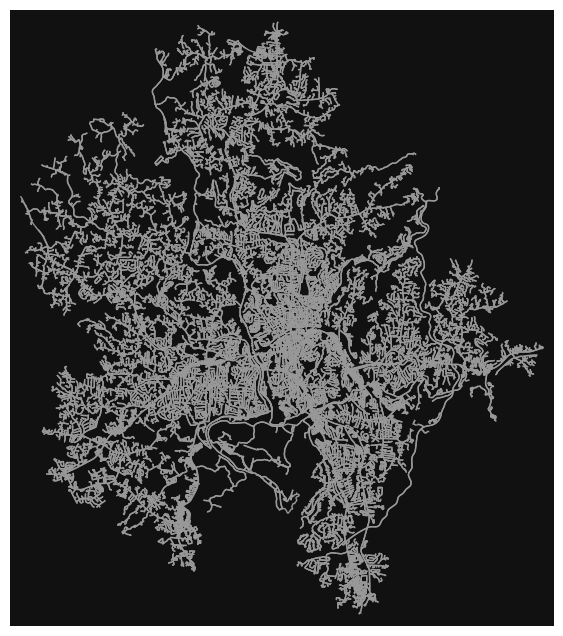

In [4]:
fig, ax = ox.plot_graph(G, node_size=0)

In [5]:
# add elevation data to the nodes (and calculate edge grades)
API_KEY = os.environ.get('GOOGLE_ELEVATION_API_KEY')
G = ox.elevation.add_node_elevations_google(G, api_key=API_KEY)
G = ox.elevation.add_edge_grades(G)

In [6]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,elevation,highway,geometry
osmid,,,,,,
169451021,35.582910,-82.607449,3,672.126,NaN,POINT (-82.60745 35.58291)
169451028,35.583061,-82.609634,3,666.208,NaN,POINT (-82.60963 35.58306)
169451041,35.613753,-82.541664,3,683.368,NaN,POINT (-82.54166 35.61375)
169451046,35.614209,-82.542318,3,683.799,NaN,POINT (-82.54232 35.61421)
169451060,35.593649,-82.632085,3,696.771,NaN,POINT (-82.63209 35.59365)


In [7]:
gdf_edges.iloc[0]

osmid                                                 16416552
name                                               Eola Avenue
highway                                            residential
oneway                                                   False
reversed                                                 False
length                                                 198.305
grade                                                    -0.03
grade_abs                                                 0.03
geometry     LINESTRING (-82.607449 35.58291, -82.609634 35...
lanes                                                      NaN
service                                                    NaN
maxspeed                                                   NaN
ref                                                        NaN
bridge                                                     NaN
access                                                     NaN
width                                                  

In [9]:
# summary stats re: edge grades (drops any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.convert.to_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

avg_grade = np.mean(grades)
print(f"Average street grade: {avg_grade * 100:.1f}%")

med_grade = np.median(grades)
print(f"Median street grade: {med_grade * 100:.1f}%")

Average street grade: 4.7%
Median street grade: 3.6%


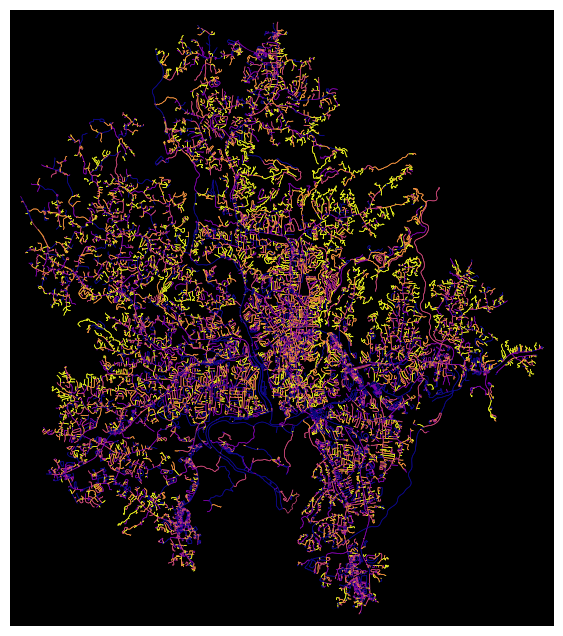

In [10]:
# edges binned and colored by grade
ec = ox.plot.get_edge_colors_by_attr(G, "grade_abs", cmap="plasma", num_bins=5, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

In [11]:
# save graph (for future analyses)
FILE_PATH = "../data/places/asheville.graphml"
ox.save_graphml(G, FILE_PATH)

In [12]:
# check that it worked
G = ox.load_graphml(FILE_PATH)
print(ox.basic_stats(G))

{'n': 24635, 'm': 58782, 'k_avg': 4.7722346255327786, 'edge_length_total': 5374142.434999959, 'edge_length_avg': 91.42496742199923, 'streets_per_node_avg': 2.476395372437589, 'streets_per_node_counts': {0: 0, 1: 6984, 2: 205, 3: 16220, 4: 1181, 5: 42, 6: 3}, 'streets_per_node_proportions': {0: 0.0, 1: 0.2834990866653136, 2: 0.008321493809620458, 3: 0.6584128272782627, 4: 0.04793992287395981, 5: 0.0017048914146539477, 6: 0.00012177795818956768}, 'intersection_count': 17651, 'street_length_total': 2759563.194000012, 'street_segment_count': 30410, 'street_length_avg': 90.74525465307504, 'circuity_avg': 1.1552530851332816, 'self_loop_proportion': 0.013022032226241369}
